# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [17]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

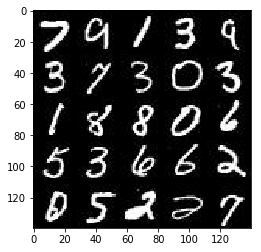

In [18]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

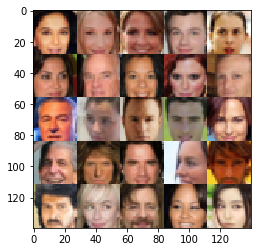

In [19]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [20]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [21]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    input_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    input_lr = tf.placeholder(tf.float32, name='input_lr')

    return input_real, input_z, input_lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [22]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')        
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
        
        return output, logits
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [23]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)        
        x1 = tf.maximum(alpha * x1, x1)
#         print (x1.shape)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, filters=256, kernel_size=4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
#         print (x2.shape)
        # 7x7x256
        
        x3 = tf.layers.conv2d_transpose(x2, filters=128, kernel_size=5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
#         print (x3.shape)
        # 14x14x128
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, filters=out_channel_dim, kernel_size=5, strides=2, padding='same')
        output = tf.tanh(logits)
#         print (output.shape)
    
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [24]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_output_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_output_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_output_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [25]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
#     d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
#     g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [26]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [27]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     tf.reset_default_graph()
#     saver = tf.train.Saver()
#     print('data_shape:', data_shape)
    
    n_numbers, image_width, image_height, image_channels = data_shape
#     image_mode = "RGB" if image_channels == 3 else "L"
    print('shape:', image_width,image_height,image_channels,data_image_mode)
    
    input_real, input_z, input_lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, input_lr, beta1)
    
    steps = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
#                 print(batch_images.shape)
                
                # Run optimizers
                sess.run(d_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, input_lr: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images, input_lr: learning_rate})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
#                     losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
            
#             print (epoch_i)
    
    print ('Finish Train')
                

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

shape: 28 28 1 L
Epoch 1/2... Discriminator Loss: 0.4006... Generator Loss: 5.9249
Epoch 1/2... Discriminator Loss: 0.5886... Generator Loss: 3.6251
Epoch 1/2... Discriminator Loss: 0.5781... Generator Loss: 2.6009
Epoch 1/2... Discriminator Loss: 0.5634... Generator Loss: 2.2909
Epoch 1/2... Discriminator Loss: 0.3960... Generator Loss: 3.3737


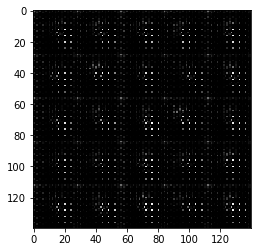

Epoch 1/2... Discriminator Loss: 1.6554... Generator Loss: 0.5321
Epoch 1/2... Discriminator Loss: 0.6363... Generator Loss: 2.3715
Epoch 1/2... Discriminator Loss: 0.6799... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.1061... Generator Loss: 2.5395


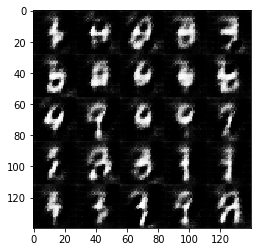

Epoch 1/2... Discriminator Loss: 1.4090... Generator Loss: 3.7400
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.5809
Epoch 1/2... Discriminator Loss: 1.2186... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.3299... Generator Loss: 0.8145
Epoch 1/2... Discriminator Loss: 1.0221... Generator Loss: 1.2765


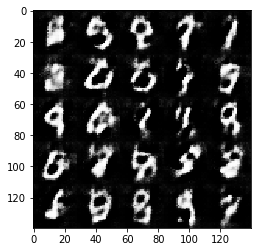

Epoch 1/2... Discriminator Loss: 1.4987... Generator Loss: 0.4573
Epoch 1/2... Discriminator Loss: 1.4706... Generator Loss: 0.5951
Epoch 1/2... Discriminator Loss: 1.1427... Generator Loss: 1.3296
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.6088
Epoch 1/2... Discriminator Loss: 1.1796... Generator Loss: 1.3619


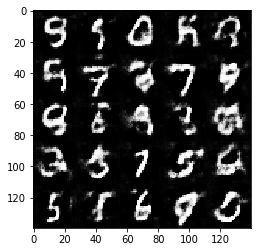

Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.0781
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.0965... Generator Loss: 0.7934
Epoch 1/2... Discriminator Loss: 1.1845... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 1.1704


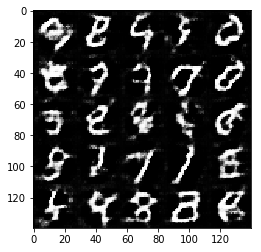

Epoch 1/2... Discriminator Loss: 1.1386... Generator Loss: 1.3853
Epoch 1/2... Discriminator Loss: 1.2981... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2372... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 1.0981... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 1.5412... Generator Loss: 0.4226


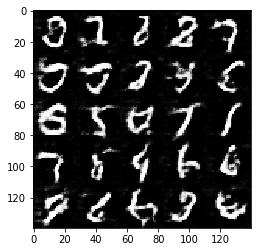

Epoch 1/2... Discriminator Loss: 1.1053... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.3676... Generator Loss: 0.5068
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.9161
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 1.4371... Generator Loss: 1.9708


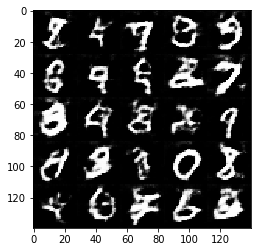

Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.0940... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.6497
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3383
Epoch 1/2... Discriminator Loss: 1.5585... Generator Loss: 1.9936


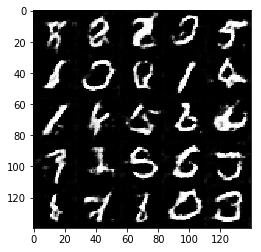

Epoch 1/2... Discriminator Loss: 1.1249... Generator Loss: 1.3156
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 0.8905
Epoch 1/2... Discriminator Loss: 1.0755... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.5151... Generator Loss: 1.9205
Epoch 1/2... Discriminator Loss: 1.5340... Generator Loss: 0.4787


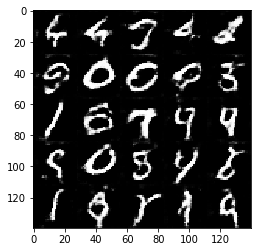

Epoch 1/2... Discriminator Loss: 1.0784... Generator Loss: 1.1148
Epoch 2/2... Discriminator Loss: 1.3107... Generator Loss: 0.5627
Epoch 2/2... Discriminator Loss: 1.0132... Generator Loss: 1.5080
Epoch 2/2... Discriminator Loss: 0.9727... Generator Loss: 1.0447
Epoch 2/2... Discriminator Loss: 1.1212... Generator Loss: 1.1827


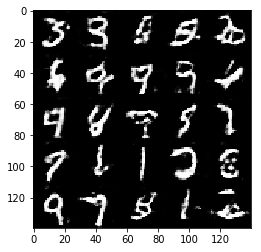

Epoch 2/2... Discriminator Loss: 0.9372... Generator Loss: 1.4277
Epoch 2/2... Discriminator Loss: 1.1127... Generator Loss: 0.8364
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.2052... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.6539... Generator Loss: 0.3909


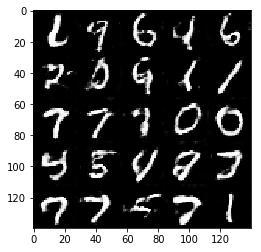

Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 1.0277
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 1.2220
Epoch 2/2... Discriminator Loss: 1.0077... Generator Loss: 1.0133
Epoch 2/2... Discriminator Loss: 1.2313... Generator Loss: 0.6545
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 1.0447


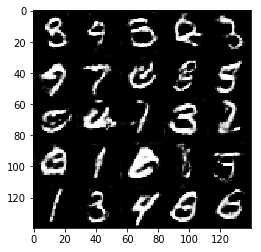

Epoch 2/2... Discriminator Loss: 1.1113... Generator Loss: 0.7519
Epoch 2/2... Discriminator Loss: 1.9955... Generator Loss: 2.8132
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 1.0161... Generator Loss: 1.0050
Epoch 2/2... Discriminator Loss: 0.9704... Generator Loss: 1.3376


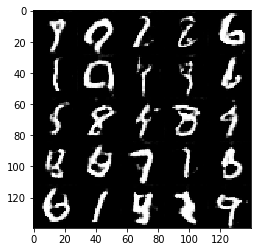

Epoch 2/2... Discriminator Loss: 1.4608... Generator Loss: 2.7148
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 1.4163
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 0.8840
Epoch 2/2... Discriminator Loss: 1.6863... Generator Loss: 0.4102
Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 0.6570


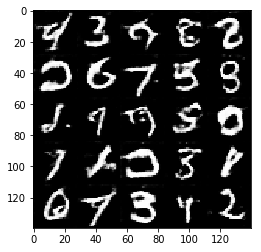

Epoch 2/2... Discriminator Loss: 0.9334... Generator Loss: 1.1021
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.8518
Epoch 2/2... Discriminator Loss: 0.8040... Generator Loss: 1.4143
Epoch 2/2... Discriminator Loss: 0.9284... Generator Loss: 1.0184
Epoch 2/2... Discriminator Loss: 1.1084... Generator Loss: 0.9915


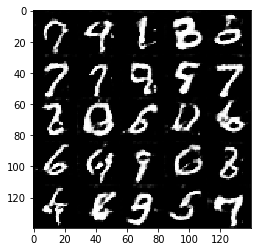

Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 1.3551... Generator Loss: 0.6131
Epoch 2/2... Discriminator Loss: 1.0328... Generator Loss: 0.8099
Epoch 2/2... Discriminator Loss: 1.1165... Generator Loss: 0.7248
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.4813


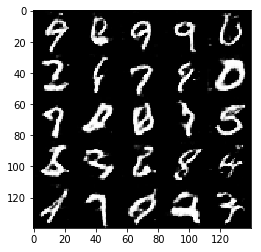

Epoch 2/2... Discriminator Loss: 1.5742... Generator Loss: 0.4096
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6302
Epoch 2/2... Discriminator Loss: 0.7060... Generator Loss: 1.5176
Epoch 2/2... Discriminator Loss: 1.1454... Generator Loss: 2.4479
Epoch 2/2... Discriminator Loss: 0.7976... Generator Loss: 1.1947


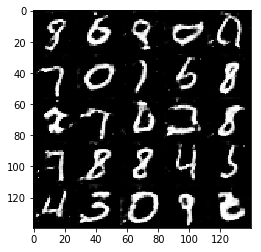

Epoch 2/2... Discriminator Loss: 0.9373... Generator Loss: 1.5377
Epoch 2/2... Discriminator Loss: 0.9171... Generator Loss: 1.5181
Epoch 2/2... Discriminator Loss: 1.0799... Generator Loss: 0.7576
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.8481


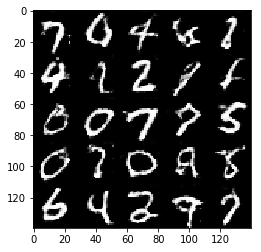

Epoch 2/2... Discriminator Loss: 1.0619... Generator Loss: 0.8284
Epoch 2/2... Discriminator Loss: 1.0797... Generator Loss: 0.8433
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 0.8531
Finish Train


In [15]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
# print (mnist_dataset.get_batches)
# print (mnist_dataset.shape)
# print (mnist_dataset.image_mode)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

shape: 28 28 3 RGB
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 13.3974
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 3.3733
Epoch 1/1... Discriminator Loss: 0.8805... Generator Loss: 1.4515
Epoch 1/1... Discriminator Loss: 0.8171... Generator Loss: 1.7798
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.6936


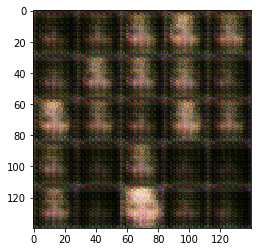

Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.6716... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.4987... Generator Loss: 1.7500


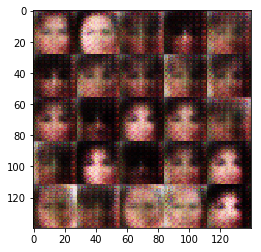

Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 1.1425
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.8251
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3421... Generator Loss: 0.7599


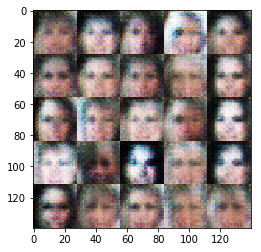

Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.5163
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.9520
Epoch 1/1... Discriminator Loss: 1.4838... Generator Loss: 1.3966
Epoch 1/1... Discriminator Loss: 2.2133... Generator Loss: 2.9055
Epoch 1/1... Discriminator Loss: 1.0672... Generator Loss: 1.2904


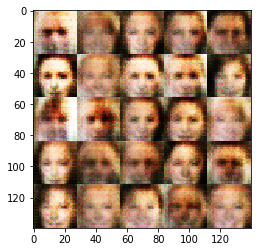

Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.1775
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 1.4606
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 1.7891
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.5032


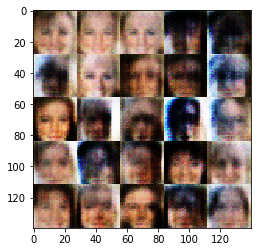

Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.1040... Generator Loss: 1.6815
Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 0.7706... Generator Loss: 1.5283
Epoch 1/1... Discriminator Loss: 1.1745... Generator Loss: 0.6626


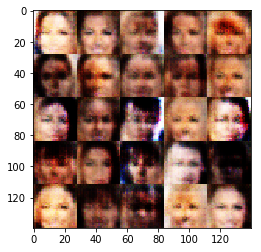

Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.4015
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.9932
Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.8034... Generator Loss: 2.1865
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.5434


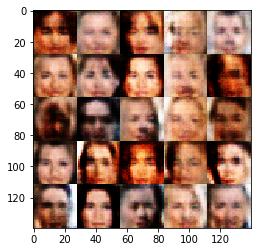

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0690
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 1.7452
Epoch 1/1... Discriminator Loss: 1.1536... Generator Loss: 0.9782


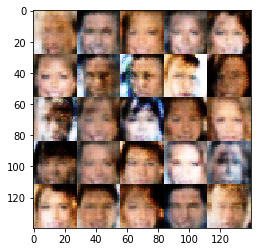

Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.8023
Epoch 1/1... Discriminator Loss: 1.7924... Generator Loss: 0.3107
Epoch 1/1... Discriminator Loss: 1.6416... Generator Loss: 0.3581
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.5431


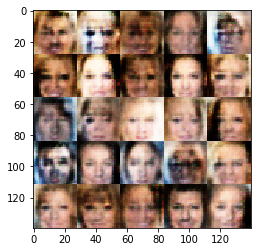

Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.5700
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.9899... Generator Loss: 2.3862
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 2.0880
Epoch 1/1... Discriminator Loss: 0.8156... Generator Loss: 1.3517


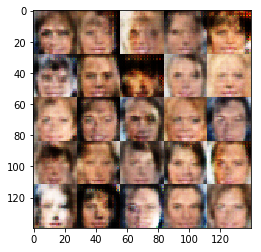

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.5464
Epoch 1/1... Discriminator Loss: 1.2516... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.8946


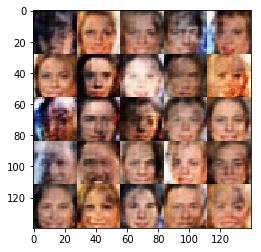

Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 1.8057
Epoch 1/1... Discriminator Loss: 0.8987... Generator Loss: 1.7321
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.9020
Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 1.5935


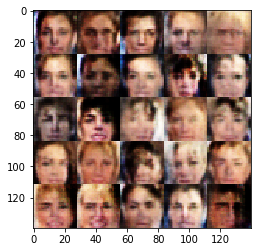

Epoch 1/1... Discriminator Loss: 1.1374... Generator Loss: 1.0399
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2176... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7492


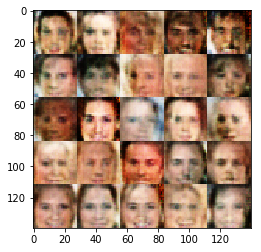

Epoch 1/1... Discriminator Loss: 1.8650... Generator Loss: 2.0871
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 0.9659... Generator Loss: 1.7379
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 1.2205


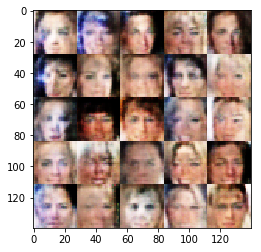

Epoch 1/1... Discriminator Loss: 1.0910... Generator Loss: 1.2339
Epoch 1/1... Discriminator Loss: 1.4825... Generator Loss: 0.4428
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 1.6525
Epoch 1/1... Discriminator Loss: 1.2788... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.8213


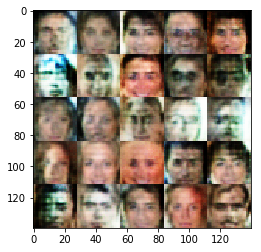

Epoch 1/1... Discriminator Loss: 1.3128... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.9931
Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.8989
Finish Train


In [28]:
batch_size = 128
z_dim = 100
learning_rate = 0.0004
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。